In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers, models


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [7]:
BATCH_SIZE=2048
EPOCHS=15

In [8]:
# def evaluate_given_keras_model(model_builder, scheduler=None, folds=5, prefix="data_no_features/fold_", epochs=EPOCHS, batch_size=BATCH_SIZE, thresholds=[0.5],verbose=1):
#     auc_scores = []
#     all_y_true = []
#     all_y_pred_prob = []
#     mean_fpr = np.linspace(0, 1, 100)
#     tprs = []

#     for i in range(folds):
#         # Wczytanie danych
#         train = pd.read_csv(f"{prefix}{i+1}_train_no_features.csv")
#         test = pd.read_csv(f"{prefix}{i+1}_test_no_features.csv")

#         train.iloc[:, 0] = train.iloc[:, 0].apply(lambda x: 1 if x > 1 else x)
#         test.iloc[:, 0] = test.iloc[:, 0].apply(lambda x: 1 if x > 1 else x)

#         # scaler = MinMaxScaler()
#         # train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
#         # test = pd.DataFrame(scaler.transform(test), columns=test.columns)

#         X_train = train.iloc[:, 1:].values
#         y_train = train.iloc[: ,0].values

#         X_test = test.iloc[:, 1:].values
#         y_test = test.iloc[: ,0].values

#         model = model_builder(X_train.shape[1])
#         callbacks = [scheduler] if scheduler else []

#         model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
#                   verbose=verbose, callbacks=callbacks,validation_data=(X_test,y_test))

#         # Predykcja prawdopodobieństw
#         y_pred_prob = model.predict(X_test).ravel()
#         all_y_pred_prob.extend(y_pred_prob)
#         all_y_true.extend(y_test)

#         # ROC
#         fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
#         interp_tpr = np.interp(mean_fpr, fpr, tpr)
#         interp_tpr[0] = 0.0
#         tprs.append(interp_tpr)
#         auc_scores.append(auc(fpr, tpr))

#     # Zamiana na array
#     all_y_true = np.array(all_y_true)
#     all_y_pred_prob = np.array(all_y_pred_prob)

#     # Średni AUC
#     mean_auc = np.mean(auc_scores)

#     # Metryki dla różnych progów
#     print("\nWyniki dla różnych wartości threshold:")
#     for thresh in thresholds:
#         y_pred = (all_y_pred_prob >= thresh).astype(int)
#         cm = confusion_matrix(all_y_true, y_pred)
#         tn, fp, fn, tp = cm.ravel()

#         accuracy = (tp + tn) / (tp + tn + fp + fn)

#         precision=  tp / (tp+fp)if (tp+fp) > 0 else 0
#         sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
#         specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
#         F1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

#         print(f"\nThreshold = {thresh}")
#         print(f"Accuracy:     {accuracy:.4f}")
#         print(f"F1:           {F1:.4f}")
#         print(f"Precision:    {precision:.4f}")
#         print(f"Sensitivity:  {sensitivity:.4f}")
#         print(f"Specificity:  {specificity:.4f}")
#         print(f"TP:           {tp}")
#         print(f"FP:           {fp}")
#         print(f"TN:           {tn}")
#         print(f"FN:           {fn}")
#         print("         Pred 1    Pred 0")
#         print(f"True 1    {tp:4}     {fn:4}")
#         print(f"True 0    {fp:4}     {tn:4}")


#     print(f"AUC= {mean_auc:.4f}")
#     # Średnia krzywa ROC
#     mean_tpr = np.mean(tprs, axis=0)
#     mean_tpr[-1] = 1.0
#     plt.figure(figsize=(8, 6))
#     plt.plot(mean_fpr, mean_tpr, label=f'ROC (AUC = {mean_auc:.4f})')
#     plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Średnia krzywa ROC (5-fold)')
#     plt.legend(loc='lower right')
#     plt.grid(True)
#     plt.show()


In [9]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def evaluate_given_keras_model(model_builder, scheduler=None, folds=5, prefix="data_no_features/fold_", 
                                epochs=EPOCHS, batch_size=BATCH_SIZE, thresholds=[0.5], verbose=1):
    auc_scores = []
    all_y_true = []
    all_y_pred_prob = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []

    fold_preds = []
    fold_trues = []

    for i in range(folds):
        train = pd.read_csv(f"{prefix}{i+1}_train_no_features.csv")
        test = pd.read_csv(f"{prefix}{i+1}_test_no_features.csv")

        train.iloc[:, 0] = train.iloc[:, 0].apply(lambda x: 1 if x > 1 else x)
        test.iloc[:, 0] = test.iloc[:, 0].apply(lambda x: 1 if x > 1 else x)

        X_train = train.iloc[:, 1:].values
        y_train = train.iloc[:, 0].values
        X_test = test.iloc[:, 1:].values
        y_test = test.iloc[:, 0].values

        model = model_builder(X_train.shape[1])
        callbacks = [scheduler] if scheduler else []

        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                  verbose=verbose, callbacks=callbacks, validation_data=(X_test, y_test))

        y_pred_prob = model.predict(X_test).ravel()
        all_y_pred_prob.extend(y_pred_prob)
        all_y_true.extend(y_test)

        fold_preds.append(y_pred_prob)
        fold_trues.append(y_test)

        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        auc_scores.append(auc(fpr, tpr))

    all_y_true = np.array(all_y_true)
    all_y_pred_prob = np.array(all_y_pred_prob)
    mean_auc = np.mean(auc_scores)

    print("\nWyniki dla różnych wartości threshold:")
    for thresh in thresholds:
        metryki = {
            'acc': [],
            'f1': [],
            'precision': [],
            'sensitivity': [],
            'specificity': [],
            'mcc': [],
            'tp': [],
            'fp': [],
            'tn': [],
            'fn': []
        }

        for y_true, y_pred_prob in zip(fold_trues, fold_preds):
            y_pred = (y_pred_prob >= thresh).astype(int)
            cm = confusion_matrix(y_true, y_pred)
            tn, fp, fn, tp = cm.ravel()

            acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
            prec = tp / (tp + fp) if (tp + fp) > 0 else 0
            sens = tp / (tp + fn) if (tp + fn) > 0 else 0
            spec = tn / (tn + fp) if (tn + fp) > 0 else 0
            f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

            denom = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
            mcc = ((tp * tn) - (fp * fn)) / denom if denom > 0 else 0

            # Zbieranie
            metryki['acc'].append(acc)
            metryki['f1'].append(f1)
            metryki['precision'].append(prec)
            metryki['sensitivity'].append(sens)
            metryki['specificity'].append(spec)
            metryki['mcc'].append(mcc)
            metryki['tp'].append(tp)
            metryki['fp'].append(fp)
            metryki['tn'].append(tn)
            metryki['fn'].append(fn)

        def mean_std(lst):
            return f"{np.mean(lst):.4f} ± {np.std(lst):.4f}"

        print(f"\nThreshold = {thresh}")
        print(f"Accuracy:     {mean_std(metryki['acc'])}")
        print(f"F1:           {mean_std(metryki['f1'])}")
        print(f"Precision:    {mean_std(metryki['precision'])}")
        print(f"Sensitivity:  {mean_std(metryki['sensitivity'])}")
        print(f"Specificity:  {mean_std(metryki['specificity'])}")
        print(f"MCC:          {mean_std(metryki['mcc'])}")
        print(f"TP:           {mean_std(metryki['tp'])}")
        print(f"FP:           {mean_std(metryki['fp'])}")
        print(f"TN:           {mean_std(metryki['tn'])}")
        print(f"FN:           {mean_std(metryki['fn'])}")

    print(f"\nŚredni AUC = {mean_auc:.4f}")
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    plt.figure(figsize=(8, 6))
    plt.plot(mean_fpr, mean_tpr, label=f'ROC (AUC = {mean_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Średnia krzywa ROC (5-fold)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


## DENSE

Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7484 - loss: 0.6824 - val_accuracy: 0.6520 - val_loss: 0.6317 - learning_rate: 0.0010
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7717 - loss: 0.5248 - val_accuracy: 0.6563 - val_loss: 0.7196 - learning_rate: 0.0010
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7992 - loss: 0.4814 - val_accuracy: 0.7586 - val_loss: 0.5563 - learning_rate: 0.0010
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8415 - loss: 0.4059 - val_accuracy: 0.7564 - val_loss: 0.5092 - learning_rate: 0.0010
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8454 - loss: 0.3817 - val_accuracy: 0.7683 - val_loss: 0.5056 - learning_rate: 0.0010
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8564 - loss: 0.3520 - val_accuracy: 0.7888 - val_loss: 0.4640 - learning_rate: 9.0484e-04
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8643 - loss: 0.3329 - val

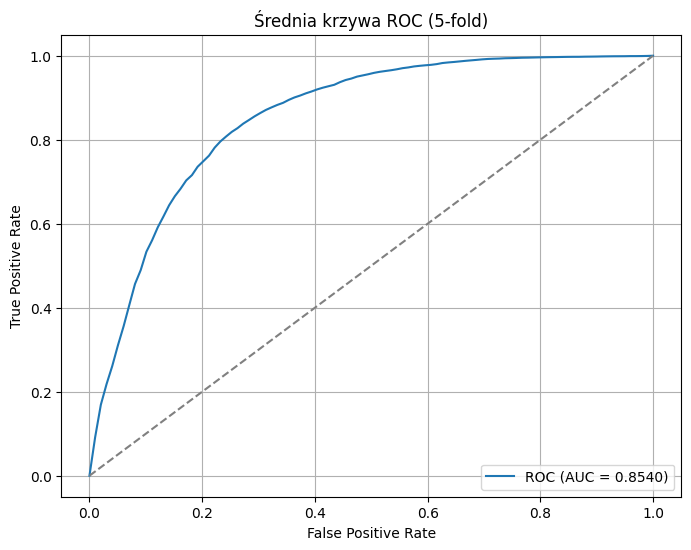

In [10]:
def custom_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

def build_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
    layers.Dense(1024, activation='relu'), 
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'), 
    layers.Dense(1, activation='sigmoid') 
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

scheduler = LearningRateScheduler(custom_scheduler)
evaluate_given_keras_model(build_model,thresholds=[0.3, 0.5, 0.7], scheduler=scheduler)

## CNN

Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 518ms/step - accuracy: 0.7323 - loss: 0.6016 - val_accuracy: 0.6044 - val_loss: 0.6729 - learning_rate: 0.0010
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 507ms/step - accuracy: 0.7776 - loss: 0.4745 - val_accuracy: 0.7362 - val_loss: 0.6131 - learning_rate: 0.0010
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 512ms/step - accuracy: 0.8324 - loss: 0.4172 - val_accuracy: 0.7417 - val_loss: 0.5964 - learning_rate: 0.0010
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 518ms/step - accuracy: 0.8407 - loss: 0.3979 - val_accuracy: 0.7601 - val_loss: 0.5519 - learning_rate: 0.0010
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 525ms/step - accuracy: 0.8496 - loss: 0.3710 - val_accuracy: 0.7665 - val_loss: 0.5312 - learning_rate: 0.0010
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 545ms/step - accuracy: 0.8531 - loss: 0.3570 - val_accuracy: 0.7703 - val_loss: 0.5226 - learning_rate: 9.0484e-04
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 550ms/step - accuracy: 0.8557 - loss

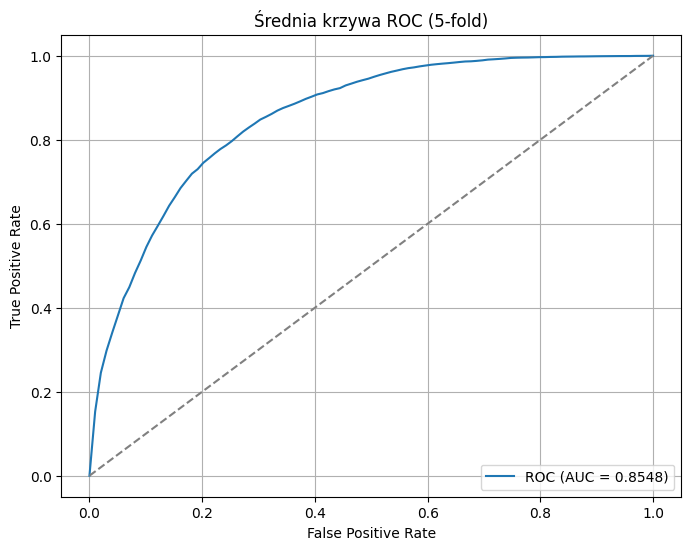

In [11]:
def custom_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

def build_model(input_dim):
    model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Reshape((input_dim, 1)), 
    layers.Conv1D(64, (3), activation='relu'),
    layers.MaxPooling1D((2)),
    layers.Conv1D(32, (3), activation='relu'),
    layers.MaxPooling1D((2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

scheduler = LearningRateScheduler(custom_scheduler)
evaluate_given_keras_model(build_model,thresholds=[0.3, 0.5, 0.7], scheduler=scheduler)

## CNN-LSTM

In [ ]:
def custom_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

def build_model(input_dim):
    model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Reshape((input_dim, 1)), 
    layers.Conv1D(64, (3), activation='relu'),
    layers.MaxPooling1D((2)),
    layers.Conv1D(32, (3), activation='relu'),
    layers.MaxPooling1D((2)),
    # layers.Flatten(),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32, return_sequences=False),
    layers.Dense(1, activation='sigmoid')
])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

scheduler = LearningRateScheduler(custom_scheduler)
evaluate_given_keras_model(build_model,thresholds=[0.3, 0.5, 0.7], scheduler=scheduler)

Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7526 - loss: 0.6268 - val_accuracy: 0.6036 - val_loss: 0.7194 - learning_rate: 0.0010
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7491 - loss: 0.5620 - val_accuracy: 0.6036 - val_loss: 0.7038 - learning_rate: 0.0010
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7486 - loss: 0.5407 - val_accuracy: 0.6036 - val_loss: 0.7633 - learning_rate: 0.0010
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7503 - loss: 0.5338 - val_accuracy: 0.6036 - val_loss: 0.7119 - learning_rate: 0.0010
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7529 - loss: 0.5150 - val_accuracy: 0.6036 - val_loss: 0.8068 - learning_rate: 0.0010
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7508 - loss: 0.5208 - val_accuracy: 0.6037 - val_loss: 0.6959 - learning_rate: 9.0484e-04
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7558 - loss: 0.4889 - val_accura

## LSTM

Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 225s 9s/step - accuracy: 0.7454 - loss: 0.6152 - val_accuracy: 0.7429 - val_loss: 0.5691 - learning_rate: 0.0010
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 229s 9s/step - accuracy: 0.7458 - loss: 0.5649 - val_accuracy: 0.7429 - val_loss: 0.5558 - learning_rate: 0.0010
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 233s 9s/step - accuracy: 0.7484 - loss: 0.5528 - val_accuracy: 0.7429 - val_loss: 0.5673 - learning_rate: 0.0010
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 236s 9s/step - accuracy: 0.7487 - loss: 0.5576 - val_accuracy: 0.7512 - val_loss: 0.4465 - learning_rate: 0.0010
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 238s 9s/step - accuracy: 0.7512 - loss: 0.5357 - val_accuracy: 0.7429 - val_loss: 0.5776 - learning_rate: 0.0010
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 239s 9s/step - accuracy: 0.7472 - loss: 0.5682 - val_accuracy: 0.7429 - val_loss: 0.5701 - learning_rate: 9.0484e-04
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 240s 9s/step - accuracy: 0.7481 - loss: 0.5646 - val

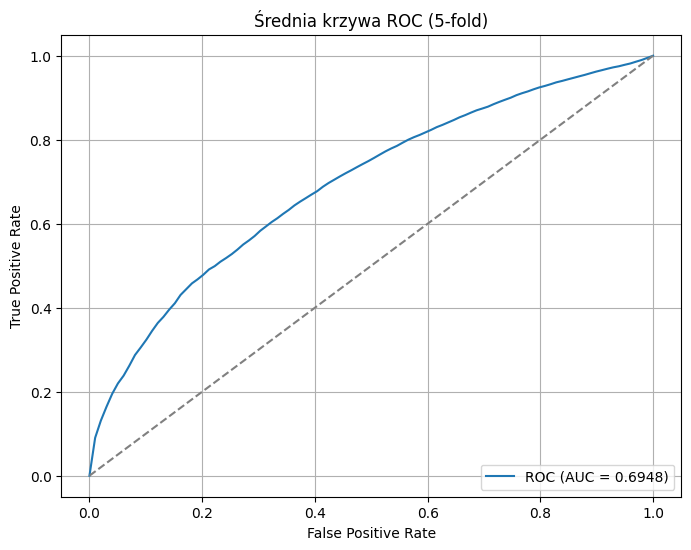

In [ ]:
def custom_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

def build_model(input_dim):
    model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Reshape((input_dim, 1)), 
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32, return_sequences=False),
    layers.Dense(1, activation='sigmoid') 
])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

scheduler = LearningRateScheduler(custom_scheduler)
evaluate_given_keras_model(build_model,thresholds=[0.3, 0.5, 0.7], scheduler=scheduler)